# TRANSIENT UNIVERSE
In this case we have data reporting measured values of the flux with the errors given as a function of the time of measurement.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee
import time
import corner

In [102]:
file = open("../solutions/transient.npy", 'rb')
data = np.load(file)
times = data[:,0]
fluxes = data[:,1]
err_flux = data[:,2]

Text(0.5, 1.0, 'Flux vs time')

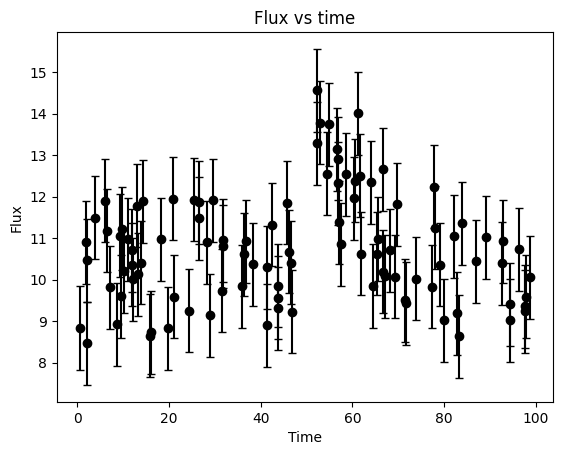

In [167]:
plt.errorbar(times, fluxes, xerr = None, yerr = err_flux, fmt = 'o', color = 'black', capsize = 3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux vs time")

We try to model the behaviour of the flux with a function representing a "burst": a background with a sudden spike modelled with an exponential:
$$F(t) = b + \theta (t - t_0) e ^ {-\alpha (t - t_0)},$$
with $\theta$ the usual Heaviside function. We want to find the probability a posteriori of the four parameters of the model given that the data are distributed normally with the error given and the mean given by the model at the time measured, whereas for the distribution of the data a priori we consider:
1) $b \in \mathrm{Unif}[0.0, 50.0]$;
2) $A \in \mathrm{Unif}[0.0, 50.0]$;
3) $t_0 \in \mathrm{Unif}[0.0, 100.0]$;
4) $\ln \alpha \in \mathrm{Unif}[-5, 5]$.

We proceed in computing the distribution a posteriori and we sample it using an MCMC.

In [104]:
def burst(x, data):
    return x[0] + (data > x[2]) * x[1] * np.exp(-x[3] * (data-x[2])) # x = [b, A, t0, alpha]

def log_likelihood(x, sigma, data_x, data_y):
    return -np.sum(((data_y - burst(x, data_x)) / (sigma))**2.0)/2.0

def prior_b(b, b_lim):
    return st.uniform(b_lim[0], b_lim[1] - b_lim[0]).pdf(b)
    #return 1.0/(b_lim[1] - b_lim[0])

def prior_A(A, A_lim):
    return st.uniform(A_lim[0], A_lim[1] - A_lim[0]).pdf(A)
    #return 1.0/(A_lim[1] - A_lim[0])
    
def prior_t0(t0, t0_lim):
    return st.uniform(t0_lim[0], t0_lim[1] - t0_lim[0]).pdf(t0)
    #return 1.0/(t0_lim[1] - t0_lim[0])
    
def prior_alpha(alpha, logalpha_lim):
    return (np.exp(logalpha_lim[0]) < alpha) * (alpha < np.exp(logalpha_lim[1]))/alpha
    #return 1.0/(logalpha_lim[1] - logalpha_lim[0]) / alpha
    
def prior(x, x_lim):
    return prior_b(x[0], x_lim[0]) * prior_A(x[1], x_lim[1]) * prior_t0(x[2], x_lim[2]) * prior_alpha(x[3], x_lim[3])

def log_posterior(x, x_lim, data_x, data_y, err_y):
    log_prior = np.log(prior(x, x_lim))
    if not np.isfinite(log_prior):
        return -np.inf
    else:
        return log_likelihood(x, err_y, data_x, data_y) + log_prior
        #return (likelihood(x, err_y, data_x, data_y) * prior(x, x_lim))

We set the initial values of the parameter. We set them randomly near values picked up looking a bit at the graph of the data. In any case, due to the properties of the Markov chain, the probability distribution reached is independento of the beginning of the chain.

In [106]:
np.random.seed(20)
#init_par = 50 * np.random.random((n_walkers, n_par))
init_par = np.full((n_walkers, n_par), [10.0, 4.0, 50.0, 1.0])
for i in range(n_walkers):
    for j in range(n_par):
        init_par[i][j] = init_par[i][j] * st.uniform(0.9, 0.2).rvs(1)

print(init_par)

[[10.1762616   4.31817098 53.91530729  1.0631675 ]
 [ 9.07177917  4.15340607 48.78680942  1.00370219]
 [10.31590293  3.75508017 47.72316402  1.04372119]
 [10.56600722  4.28026211 52.75244894  0.90733286]
 [ 9.23338747  4.20102456 47.39218216  0.9509612 ]
 [10.71525106  4.35982322 50.61686858  0.9357561 ]
 [10.54050387  3.99390483 51.31253066  1.06789958]
 [ 9.92207879  3.99835206 51.79411118  1.03015718]]


/tmp/ipykernel_8416/3006440275.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_par[i][j] = init_par[i][j] * st.uniform(0.9, 0.2).rvs(1)


In [112]:
x_lim = np.array([[0.0, 50.0], [0.0, 50.0], [0.0, 100.0], [-5.0, 5.0]])
n_par = 4
n_walkers = 8
n_step = 200000

sampler = emcee.EnsembleSampler(n_walkers, n_par, log_posterior, args=[x_lim, times, fluxes, err_flux], moves=emcee.moves.StretchMove(2.7))
elapsed = time.time()
sampler.run_mcmc(init_par, n_step)
print("done, {}".format(time.time() - elapsed))

/tmp/ipykernel_8416/4012376348.py:27: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(prior(x, x_lim))


done, 1675.6313195228577


We check at the acceptance rate. It should be between 20% and 50%:

In [113]:
print("Acceptance rates for every walker:")
print(sampler.acceptance_fraction)

Acceptance rates for every walker:
[0.408875 0.410165 0.4082   0.408625 0.407075 0.411645 0.409395 0.408775]


Then we look at the trace plots:

Text(0.5, 0.98, 'Trace-plots')

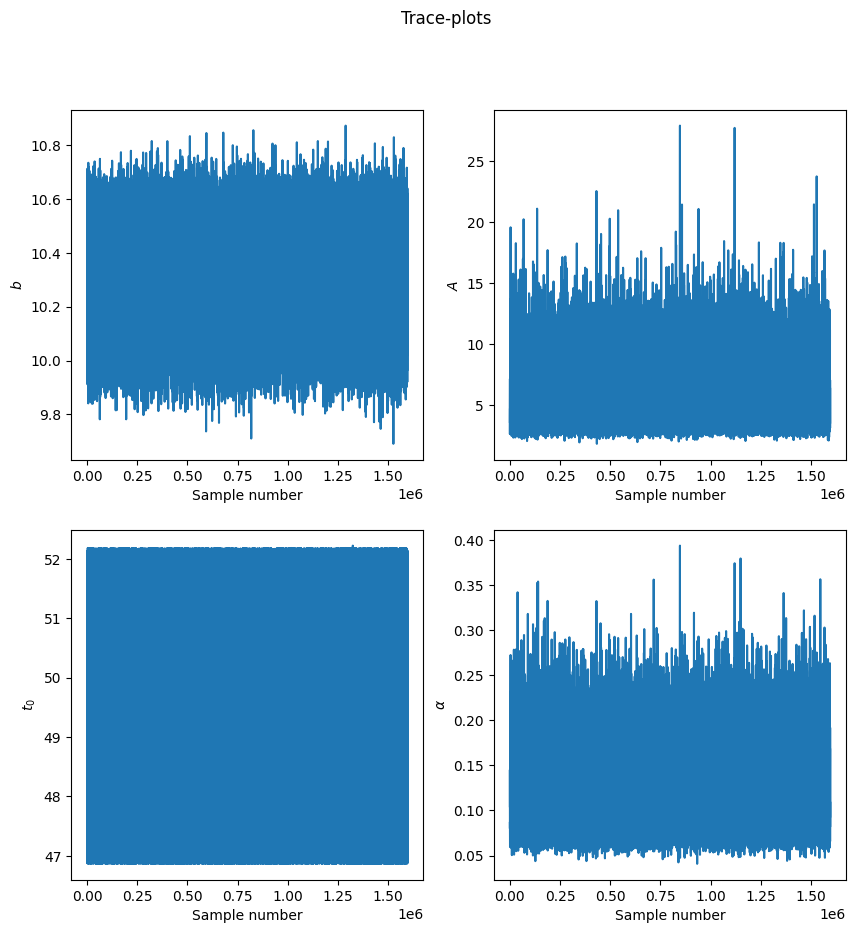

In [170]:
burn_in = 500
samples = sampler.chain[:, burn_in:, :]
samples = np.reshape(samples, (-1, n_par))

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.plot(range(np.size(samples[:, 0])), samples[:, 0])
plt.xlabel("Sample number")
plt.ylabel(r"$b$")
plt.subplot(2,2,2)
plt.plot(range(np.size(samples[:, 1])), samples[:, 1])
plt.xlabel("Sample number")
plt.ylabel(r"$A$")
plt.subplot(2,2,3)
plt.plot(range(np.size(samples[:, 2])), samples[:, 2])
plt.xlabel("Sample number")
plt.ylabel(r"$t_0$")
plt.subplot(2,2,4)
plt.plot(range(np.size(samples[:, 3])), samples[:, 3])
plt.xlabel("Sample number")
plt.ylabel(r"$\alpha$")
fig.suptitle("Trace-plots")

The distribution seems to be well-sampled, so we can compute the autocorrelation length and thin the data:

In [172]:
thin = int(np.max(sampler.get_autocorr_time()) + 1)
print(thin)
decorr_sample = sampler.get_chain(discard = burn_in, thin = thin)
decorr_sample = np.reshape(decorr_sample, (-1, 4))

87


We can make a corner plot:

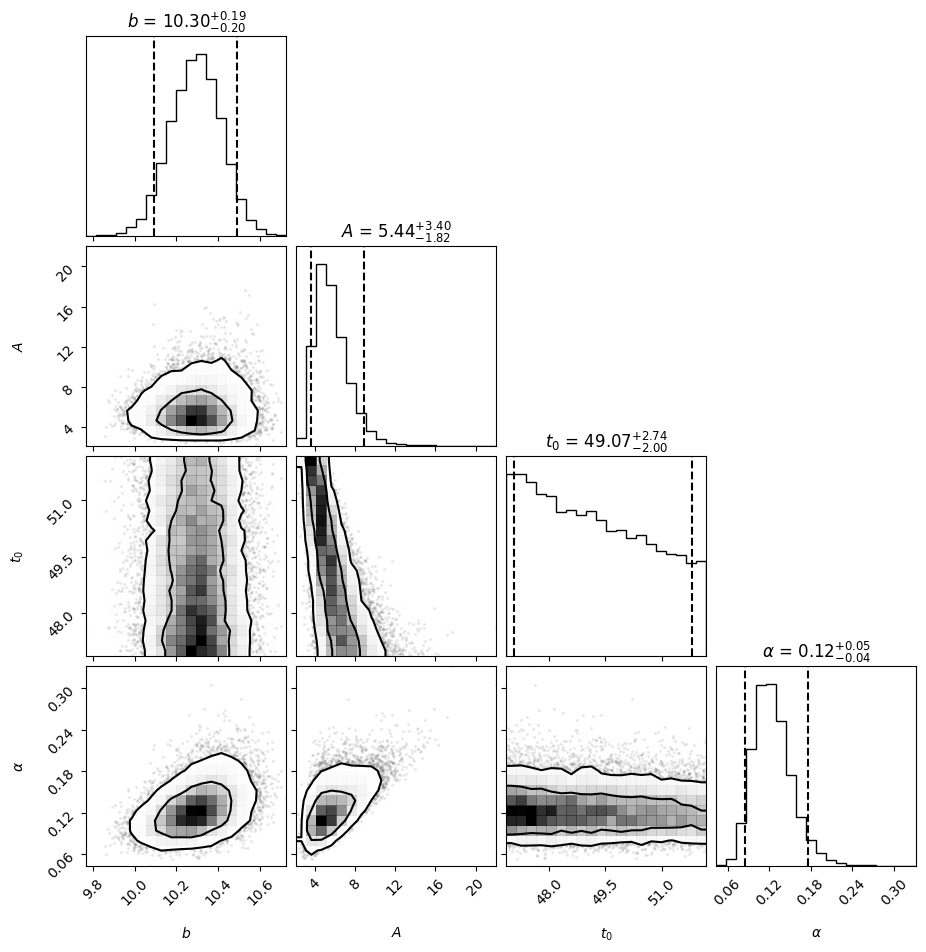

In [179]:
fig = corner.corner(decorr_sample, labels = [r"$b$", r"$A$", r"$t_0$", r"$\alpha$"], levels = (0.68,0.95),\
                    quantiles = [0.05, 0.95], show_titles=True, title_quantiles=[0.05, 0.5, 0.95])

Over the histograms of the parameters we can read the median and the 90% credible interval. We'll report them here:
1) $b = 10.30_{-0.20}^{+0.19}$
2) $A = 5.44_{-1.82}^{+3.40}$
3) $t_0 = 49.07_{-2.00}^{+2.74}$
4) $\alpha = 0.12_{-0.04}^{+0.05}$

We can see the distribution of the model over the data: we pick 100 samples of the four parameters and plot the corresponding model over the data to have an isea of the sprea

Text(0.5, 1.0, 'Model with different possible parameters')

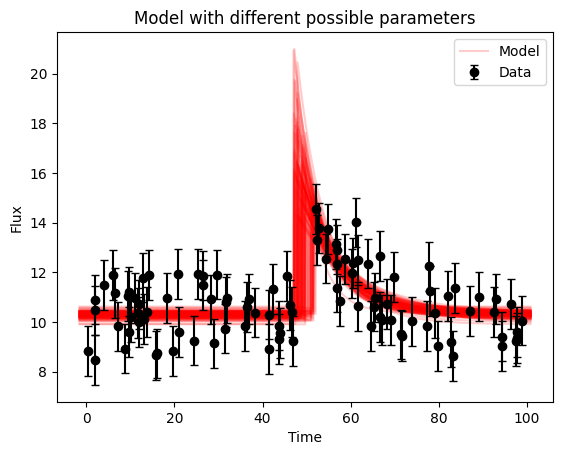

In [180]:
xgrid = np.linspace(np.min(times)-2.0, np.max(times)+2.0, 1000)
rng = np.random.default_rng()
random_par = rng.choice(decorr_sample, 100, replace=False, axis = 0)

for i in range(100):
    if i == 0:
        plt.plot(xgrid, burst(random_par[i], xgrid), color='red', alpha = 0.2, label = "Model")
    else:
        plt.plot(xgrid, burst(random_par[i], xgrid), color='red', alpha = 0.2)
plt.errorbar(times, fluxes, xerr = None, yerr = err_flux, fmt = 'o', color = 'black', capsize = 3, label = "Data")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Model with different possible parameters")